In [351]:
import numpy as np
import cv2 
import keras
import matplotlib.pyplot as plt

In [352]:
mnist=keras.datasets.mnist.load_data()

In [353]:
(x_train, y_train), (x_test, y_test)=keras.datasets.mnist.load_data()

In [380]:
class CONV_LAYER_2D():  #2d convolution layer 
    
    
    def __init__(self,num_filters,dim_of_filter=3):
        self.n_filters=num_filters #no of filters declared
        self.dim_of_filter=dim_of_filter
        #filters are of shape (n*m*m) where 
        #m=no of dimensions of kernel, and n=num of filters 
        self.filters=np.random.randn(num_filters,dim_of_filter,dim_of_filter)/dim_of_filter*dim_of_filter #normalized filters
        #random weights for filters
        
    def iterate_regions(self,image):  #generator for roi for input images
        
        h,w=image.shape #2d image shape
        
        for i in range(h-(self.dim_of_filter)+1):
            for j in range(w-(self.dim_of_filter)+1):
                roi=image[i:(i+self.dim_of_filter),j:(j+self.dim_of_filter)]

                yield roi,i,j #roi is the region of interest,i is the row,j is the col
                
    def convolve(self,image): #convolving layer
        self.last_input=image
        h,w=image.shape
        output_h=h-self.dim_of_filter+1
        output_w=w-self.dim_of_filter+1
        
        
        output_image=np.zeros((output_h,output_w,self.n_filters))
        
        for roi,i,j in self.iterate_regions(image):
            output_image[i][j]=np.sum(roi*self.filters,axis=(1,2))
            
        return output_image
    
    
    def backward(self,input,lr=0.01):
        dl_dfilters=np.zeros(self.filters.shape)
        
        for roi,i,j in self.iterate_regions(self.last_input):
            for f in range(self.n_filters):
                dl_dfilters+=input[i,j,f]*roi 
                
        self.filters-=lr*dl_dfilters
        
        
        return None
                              
        
        

In [381]:
class Max_Pooling():
    
    def iterate_regions(self,image):
        h,w,_=image.shape
        
        for i in range(h//2):
            for j in range(w//2):
                roi=image[(i * 2):(i * 2 + 2), (j * 2):(j * 2 + 2)]
                yield roi,i,j
                
    def Pool(self,image):
        self.last_shape=image.shape
        self.last_input=image
        output=np.zeros((image.shape[0]//2,image.shape[1]//2,image.shape[2]))
        
        for roi,i,j in self.iterate_regions(image):
            output[i,j]=np.max(roi,axis=(0,1))
        
        return output
    
    def backward(self,input):
        self.output=np.zeros(self.last_shape)
        
        for roi,i,j in self.iterate_regions(self.last_input):
            h,w,f=roi.shape
            maximum=np.max(roi,axis=(0,1))
            
            for i2 in range(h):
                for j2 in range(w):
                    for f2 in range(f):
                        if roi[i2,j2,f2]==maximum[f2]:
                            self.output[i*2+i2,j*2+j2,f2]=input[i,j,f2]
                            
        return self.output
                            
                
            

In [382]:
conv=CONV_LAYER_2D(10,3)
output=conv.convolve(x_train[0])
print(output.shape)
pool=Max_Pooling()
pool.Pool(output).shape

(26, 26, 10)


(13, 13, 10)

In [383]:
class Ann():
    
    def __init__(self,n_nodes,n_inputs):
        self.n_nodes=n_nodes
        self.n_ninputs=n_inputs
        self.weights=np.random.randn(n_nodes,n_inputs)
        self.bias=np.zeros(n_nodes)
        
    def forward(self,X):
        
        self.last_shape=X.shape
        
        #excepts the input to be a multidimensional array 
        X=X.flatten()
        
        self.last_inputs=X
        output=np.dot(self.weights,X)+self.bias
        
        self.last_output=output
        
        softmax_output=np.exp(output)/(np.sum(np.exp(output),axis=0))
        
        return softmax_output
    
    
    def backward(self,loss_wrt_out,learning_rate=0.01):
        for i,gradient in enumerate(loss_wrt_out):
            if gradient==0:
                continue
                
            t_exp=np.exp(self.last_output)
            
            S=np.sum(t_exp)
            
            #gradients
            d_out_dt=-t_exp[i]*t_exp/(S**2)
            d_out_dt[i]=t_exp[i]*(S-t_exp[i])/(S**2)
            
            
            #gradients of params
            dt_dw=self.last_inputs
            dt_db=1
            dt_dinput=self.weights
            
            #gradient of loss against total
            dl_dt=gradient*d_out_dt
            
            #final gradients
            dl_dw=np.dot(dt_dw[np.newaxis].T,dl_dt[np.newaxis])
            dl_db=1*dl_dt
            dl_dinputs=np.dot(dt_dinput.T,dl_dt)
            
            #update_rule
            self.weights-=learning_rate*(dl_dw.T)
            self.bias-=learning_rate*dl_db
            
            return dl_dinputs.reshape(self.last_shape)
        
nn=Ann(10,13*13*10)

In [384]:
def forward(image,label): #forward method for a single image
    image=image/255.0*0.5
    out=conv.convolve(image)
    out=pool.Pool(out)
    
    output=nn.forward(out)
    
    loss=-np.log(output[label])
    
    prediction=np.argmax(output)
    
    
    return output,loss,prediction

In [418]:
def train_network(X,y,epochs=3):
    for epoch in range(epochs):
        print(f"////// {epoch} //////")
        permutations=np.random.permutation(len(X))
        
        X=X[permutations]
        y=y[permutations]
        
        loss_nn=0
        predictions=[]
        j=0
        for image,label in zip(X,y):
            out,loss,prediction=forward(image,label)

            gradient=np.zeros(10)
            gradient[label]=-1/out[label]

            gradient=nn.backward(gradient,0.005)

            gradient_2=pool.backward(gradient)

            conv.backward(gradient_2,lr=0.005)

            loss_nn+=loss
            predictions.append(prediction)
            j+=1

            if j%100==0:
                print(f'Samples Done {j}')


        
        
    return loss_nn/(len(X)),np.mean(y==predictions),predictions
        

In [419]:
train_network(x_train[:1000],y_train[:1000])

////// 0 //////
Samples Done 100
Samples Done 200
Samples Done 300
Samples Done 400
Samples Done 500
Samples Done 600
Samples Done 700
Samples Done 800
Samples Done 900
Samples Done 1000
////// 1 //////
Samples Done 100
Samples Done 200
Samples Done 300
Samples Done 400
Samples Done 500
Samples Done 600
Samples Done 700
Samples Done 800
Samples Done 900
Samples Done 1000
////// 2 //////
Samples Done 100
Samples Done 200
Samples Done 300
Samples Done 400
Samples Done 500
Samples Done 600
Samples Done 700
Samples Done 800
Samples Done 900
Samples Done 1000


(1.6435449526384507,
 0.816,
 [9,
  2,
  3,
  1,
  2,
  0,
  1,
  8,
  5,
  8,
  8,
  6,
  7,
  9,
  2,
  6,
  7,
  7,
  4,
  2,
  9,
  0,
  1,
  1,
  5,
  1,
  0,
  0,
  0,
  5,
  1,
  6,
  9,
  1,
  3,
  8,
  3,
  4,
  0,
  2,
  3,
  1,
  0,
  0,
  2,
  2,
  9,
  5,
  1,
  3,
  9,
  1,
  5,
  0,
  5,
  4,
  9,
  1,
  7,
  4,
  2,
  5,
  9,
  6,
  7,
  2,
  5,
  7,
  0,
  1,
  3,
  1,
  9,
  1,
  1,
  7,
  3,
  2,
  2,
  5,
  4,
  4,
  1,
  1,
  8,
  5,
  1,
  2,
  7,
  6,
  0,
  6,
  4,
  1,
  9,
  4,
  0,
  4,
  2,
  1,
  8,
  4,
  5,
  0,
  7,
  7,
  0,
  4,
  4,
  1,
  9,
  5,
  1,
  4,
  3,
  4,
  5,
  6,
  7,
  8,
  0,
  3,
  7,
  4,
  2,
  4,
  2,
  8,
  7,
  7,
  0,
  6,
  1,
  3,
  7,
  1,
  3,
  4,
  8,
  0,
  5,
  0,
  9,
  2,
  7,
  3,
  1,
  9,
  1,
  9,
  6,
  8,
  6,
  0,
  2,
  1,
  7,
  7,
  8,
  0,
  0,
  3,
  0,
  0,
  7,
  5,
  9,
  2,
  2,
  7,
  6,
  7,
  8,
  6,
  7,
  9,
  1,
  1,
  7,
  1,
  2,
  6,
  1,
  3,
  7,
  6,
  3,
  1,
  1,
  6,
  8,
  1,
  8,
  2,
 

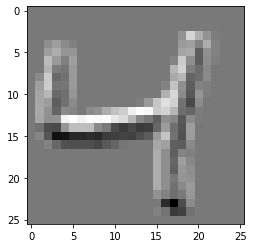

In [426]:
plt.imshow(conv.convolve(x_train[2])[:,:,3],cmap='gray')